In [65]:
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import scipy.stats as stats




airports = pd.read_csv('airports.csv')
flights = pd.read_csv('flights.csv')

/var/folders/m9/x7jxk9jx2g9ch4ngnwz3n8wh0000gn/T/ipykernel_46434/410809825.py:18: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv('flights.csv')


In [66]:
flights = flights.merge(airports, how='right', left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')

добавляю колонки час и минуты и формирую соответствующую колонку DATE
выбираю период по 30 сентября
не нашел коды аэропортов, в октябре они цифрами прописаны, поэтому теряю месяц (октябрь)

In [67]:
flights['HOUR'] = flights['SCHEDULED_DEPARTURE']//100
flights['MINUTE'] = flights['SCHEDULED_DEPARTURE']%100
flights['DATE'] = pd.to_datetime(flights[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE']])
flights = flights.loc[flights['DATE'].between('2015-01-01', '2015-09-30')]


формирую колонку C_TIME с количеством рейсов в d каждый момент DATE

In [68]:
c_time = flights.groupby('DATE').count().reset_index()
c_time['C_TIME'] = c_time['MONTH']
c_time = c_time[['DATE', 'C_TIME']]
flights = flights.merge(c_time, how='left', left_on='DATE', right_on='DATE')

создаю колонку - опоздал/прилетел в срок или ранее 

In [69]:
flights['PROBABILITY'] = np.where(flights['DEPARTURE_DELAY']>0, 0, 1)

теперь выбираю данные для обучения, все они не содержат времени, связанного с задержкой

In [79]:
my_flight = flights[['DAY_OF_WEEK', 'HOUR', 'MINUTE',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_TIME',
       'DATE', 'ARRIVAL_DELAY',
       'C_TIME', 'AIRLINE', 'FLIGHT_NUMBER', 'DISTANCE', 'TAIL_NUMBER' ]]

<AxesSubplot:xlabel='DATE'>

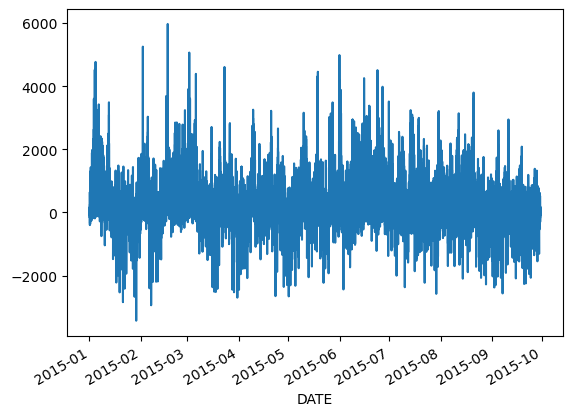

In [95]:
my_flight['DATE'].between('2015-01-01', '2015-09-30')
my_flight.groupby('DATE')['ARRIVAL_DELAY'].sum().plot()

небольшой пример

In [187]:
ATL = my_flight.query("ORIGIN_AIRPORT == 'MEM'")
ATL_IAD = ATL.query("DESTINATION_AIRPORT =='IAD'")

In [188]:
ATL_IAD.set_index('DATE', inplace=True)
ATL_IAD.drop(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], axis=1, inplace=True)

/var/folders/m9/x7jxk9jx2g9ch4ngnwz3n8wh0000gn/T/ipykernel_46434/1282734093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ATL_IAD.drop(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], axis=1, inplace=True)


In [189]:
le = LabelEncoder()
ATL_IAD.AIRLINE = le.fit_transform(ATL_IAD['AIRLINE'])
ATL_IAD.TAIL_NUMBER = le.fit_transform(ATL_IAD['TAIL_NUMBER'])

ATL_IAD.dropna(inplace=True)

/var/folders/m9/x7jxk9jx2g9ch4ngnwz3n8wh0000gn/T/ipykernel_46434/1462679028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ATL_IAD.AIRLINE = le.fit_transform(ATL_IAD['AIRLINE'])
/var/folders/m9/x7jxk9jx2g9ch4ngnwz3n8wh0000gn/T/ipykernel_46434/1462679028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ATL_IAD.TAIL_NUMBER = le.fit_transform(ATL_IAD['TAIL_NUMBER'])
/var/folders/m9/x7jxk9jx2g9ch4ngnwz3n8wh0000gn/T/ipykernel_46434/1462679028.py:5: SettingWithCopyWarning: 
A value is trying to be set on 

удаляе выбросы, считаем ошибку, можно сделать тоже в цикле для авиакомпаний

In [194]:
#for airline in ATL_IAD.AIRLINE.unique():

ATL_IAD_q = ATL_IAD

Q1 =  ATL_IAD_q['ARRIVAL_DELAY'].quantile(0.25)
Q3 = ATL_IAD_q['ARRIVAL_DELAY'].quantile(0.75)
IQR = Q3 - Q1
a = ATL_IAD_q[(ATL_IAD_q['ARRIVAL_DELAY'] < Q1-1.5*IQR ) | (ATL_IAD_q['ARRIVAL_DELAY'] > Q3+1.5*IQR)]['ARRIVAL_DELAY'].reset_index()
a = list(a.ARRIVAL_DELAY)
ATL_IAD_q.query("ARRIVAL_DELAY != @a", inplace=True)



X_train,X_test, y_train, y_test = train_test_split(ATL_IAD_q.drop('ARRIVAL_DELAY',axis=1),
                                                        ATL_IAD_q.ARRIVAL_DELAY,
                                                        shuffle = False,
                                                        test_size = 0.25)

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Ошибка на обучающей выборке', (mean_squared_error(y_train, lr.predict(X_train)))**0.5)
pred = lr.predict(X_test)
print('Ошибка на тесте', (mean_squared_error(y_test, pred))**0.5)

    
rf = RandomForestRegressor(n_estimators=10, random_state=0)
rf.fit(X_train, y_train)
print('Ошибка на обучающей выборке', (mean_squared_error(y_train, rf.predict(X_train)))**0.5)
pred = rf.predict(X_test)
print('Ошибка на тесте', (mean_squared_error(y_test, pred))**0.5)


Ошибка на обучающей выборке 11.574017239426492
Ошибка на тесте 11.741102635314075
Ошибка на обучающей выборке 6.98130837785201
Ошибка на тесте 16.754458361880875


/var/folders/m9/x7jxk9jx2g9ch4ngnwz3n8wh0000gn/T/ipykernel_46434/2944440254.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ATL_IAD_q.query("ARRIVAL_DELAY != @a", inplace=True)
